# Demo of training and interpreting EEGSimpleNet using Motor Imagery Classification

## Load all required libraries and set seed for reproducibility

In [12]:
import random
import warnings

import matplotlib.pyplot as plt
import moabb
import numpy as np
import torch
import torch.nn as nn
from moabb.datasets import Zhou2016
from moabb.paradigms import LeftRightImagery
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
from tqdm.notebook import tqdm

from architecture import EEGSimpleNet
from plot_patterns import plot_temporal_patterns, plot_topographies 


moabb.set_log_level("info")
warnings.filterwarnings("ignore")

In [13]:
def set_seed(seed):
    """Set all random seeds for reproducibility"""
    
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
# Set seeds before any other computation
set_seed(128)

## Load and resample data

In [14]:
dataset = Zhou2016()
dataset.subject_list = [1, 2, 3]
sampling_rate = 100  # Resampling to reduce overfitting

In [15]:
# This will download the dataset if it is not already present
sessions = dataset.get_data(subjects=[1])

In [16]:
paradigm = LeftRightImagery(resample=sampling_rate)

In [17]:
X, _, _ = paradigm.get_data(dataset=dataset, subjects=[1], return_epochs=True)
eeg_channels = X.ch_names
print(f"EEG channels: {eeg_channels}")
X, labels, meta = paradigm.get_data(dataset=dataset, subjects=[1])
print(X.shape, labels.shape, set(labels), meta.shape)
y = (labels == 'right_hand').astype(int)
print(f'Class balance: {np.mean(y):.02f}')

EEG channels: ['Fp1', 'Fp2', 'FC3', 'FCz', 'FC4', 'C3', 'Cz', 'C4', 'CP3', 'CPz', 'CP4', 'O1', 'Oz', 'O2']
(319, 14, 500) (319,) {'right_hand', 'left_hand'} (319, 3)
Class balance: 0.50


## Initialize model

In [18]:
filter_length = int(0.5 * sampling_rate)
if (filter_length % 2) == 0:
    filter_length += 1

model = EEGSimpleNet(
    n_eeg_channels=X.shape[1], 
    n_output=1, 
    n_branches=8, 
    window_size=X.shape[-1],
    band_pass_length=filter_length, 
    low_pass_length=filter_length,
    dropout_p=0.3
)

print(f'Model has {sum(p.numel() for p in model.parameters() if p.requires_grad)} trainable parameters')

Model has 4945 trainable parameters


## Train model

In [19]:
# Convert data to PyTorch tensors and create data loaders
X_tensor = torch.FloatTensor(X)
y_tensor = torch.FloatTensor(y)

# Split data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_tensor, y_tensor, test_size=0.2, random_state=42
)

# Create data loaders
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)  # Reduced batch size
val_loader = DataLoader(val_dataset, batch_size=16)

# Early stopping helper class
class EarlyStopping:
    def __init__(self, patience=7, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.should_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.should_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

# Define training parameters
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=5
)
early_stopping = EarlyStopping(patience=10)
n_epochs = 100
best_val_loss = float('inf')
best_model_state = None

# Main training loop with epoch progress bar
epoch_pbar = tqdm(range(n_epochs), desc='Training Progress')
for epoch in epoch_pbar:
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0
    
    # Training loop
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs.squeeze(), batch_y)
        loss.backward()
        optimizer.step()
        
        # Calculate training metrics
        train_loss += loss.item()
        predicted = (torch.sigmoid(outputs.squeeze()) > 0.5).float()
        train_total += batch_y.size(0)
        train_correct += (predicted == batch_y).sum().item()
    
    # Validation
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            outputs = model(batch_X)
            loss = criterion(outputs.squeeze(), batch_y)
            val_loss += loss.item()
            
            predicted = (torch.sigmoid(outputs.squeeze()) > 0.5).float()
            val_total += batch_y.size(0)
            val_correct += (predicted == batch_y).sum().item()

    # Calculate average losses
    avg_train_loss = train_loss/len(train_loader)
    avg_val_loss = val_loss/len(val_loader)
    
    # Learning rate scheduling
    scheduler.step(avg_val_loss)
    
    # Early stopping check
    early_stopping(avg_val_loss)
    
    # Save best model
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_model_state = model.state_dict().copy()
    
    # Update progress bar with more metrics
    epoch_pbar.set_postfix({
        'epoch': f'{epoch+1}/{n_epochs}',
        'train_loss': f'{avg_train_loss:.4f}',
        'train_acc': f'{100. * train_correct/train_total:.2f}%',
        'val_loss': f'{avg_val_loss:.4f}',
        'val_acc': f'{100. * val_correct/val_total:.2f}%',
        'lr': f'{optimizer.param_groups[0]["lr"]:.2e}'
    })
    
    if early_stopping.should_stop:
        print(f"\nEarly stopping triggered at epoch {epoch+1}")
        break

# Load best model
if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print(f"\nLoaded best model with validation loss: {best_val_loss:.4f}")

# Validation
model.eval()
val_loss = 0.0
val_correct = 0
val_total = 0

with torch.no_grad():
    for batch_X, batch_y in val_loader:
        outputs = model(batch_X)
        loss = criterion(outputs.squeeze(), batch_y)
        val_loss += loss.item()
        
        predicted = (torch.sigmoid(outputs.squeeze()) > 0.5).float()
        val_total += batch_y.size(0)
        val_correct += (predicted == batch_y).sum().item()

print(f"Validation Loss: {val_loss/len(val_loader):.4f}")
print(f"Validation Accuracy: {100. * val_correct/val_total:.2f}%")

Training Progress:   0%|          | 0/100 [00:00<?, ?it/s]


Early stopping triggered at epoch 60

Loaded best model with validation loss: 0.1790
Validation Loss: 0.1808
Validation Accuracy: 90.62%


## Interpret model weights

In [20]:
spatial_patterns, temporal_patterns, fft_freqs = model.spatio_temporal_block.calculate_patterns(eeg_data=torch.from_numpy(X[2]).float(), eeg_sampling_rate=sampling_rate)

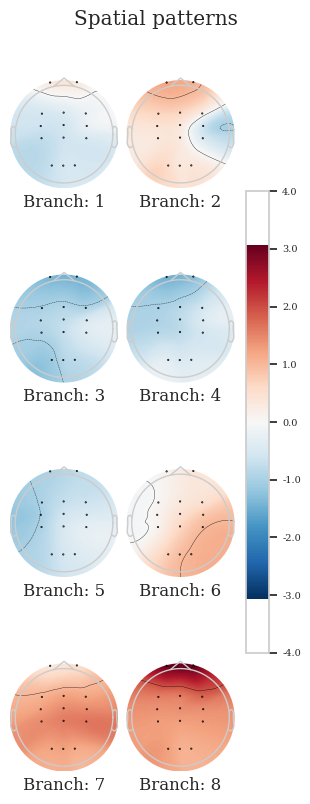

In [21]:
spatial_fig = plot_topographies(
    spatial_patterns=spatial_patterns.numpy(), eeg_channels=eeg_channels, montage_name='standard_1020', 
    save_path=None
)
plt.show()

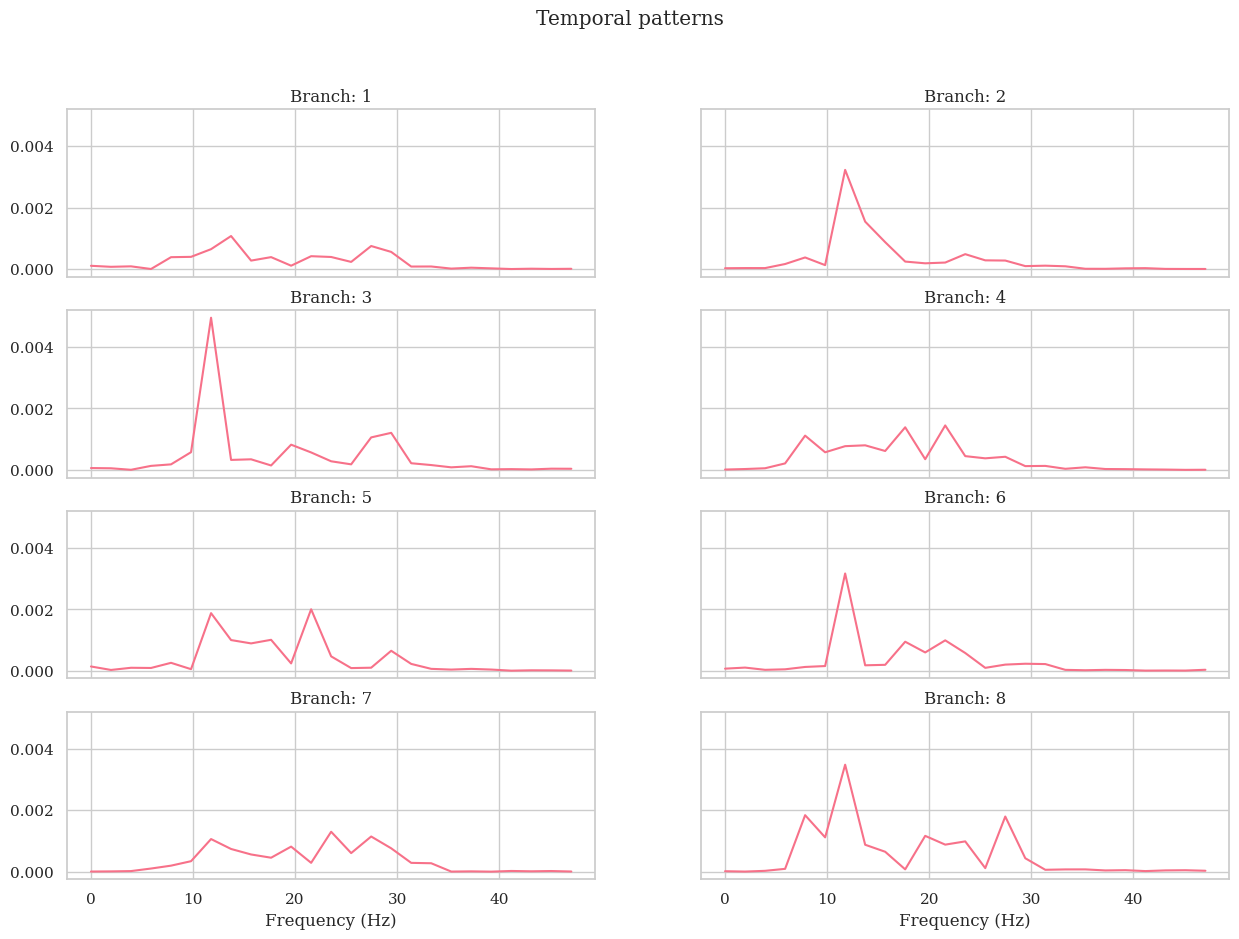

In [22]:
temporal_fig = plot_temporal_patterns(
    fft_freqs=fft_freqs.numpy(), temporal_patterns=temporal_patterns.numpy(), save_path=None
)
plt.show()